# Imports

In [1]:
from pyUtil import count_change, count_pikes
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<br>

# Data Ingestion

In [2]:
df = pd.read_csv("processminer-rare-event-mts-data.csv")

In [3]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
df[df.y==0].describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18274.0,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,...,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.0
mean,0.0,0.011198,0.194998,0.626211,-10.139593,0.006840,2.489880,0.001483,-0.004143,-0.003368,...,0.401567,0.458541,0.183983,2.454428,9.401764,0.236905,-0.001881,-0.069369,0.001252,0.0
std,0.0,0.741833,4.912832,5.898330,130.983772,0.633845,36.987546,0.108664,0.075172,0.155036,...,6.052476,4.612143,3.023366,67.891696,81.289542,2.324591,0.048760,10.428501,0.004718,0.0
min,0.0,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-16.555008,-14.211369,-8.210370,-230.574030,-269.039500,-4.888661,-0.149790,-100.810500,-0.012229,0.0
25%,0.0,-0.405828,-2.123012,-3.477843,-111.428897,-0.446864,-23.687049,-0.058658,-0.050880,-0.059966,...,-3.672684,-1.933476,0.492208,-39.882046,-45.399116,-1.598804,0.000473,0.295016,-0.001808,0.0
50%,0.0,0.128147,-0.060635,-0.161470,-14.940988,-0.120699,10.585686,-0.009338,-0.000993,-0.030057,...,0.294846,0.144222,0.712452,17.633121,1.682657,0.085826,0.012867,0.733812,0.000704,0.0
75%,0.0,0.420588,2.335692,3.443554,92.052390,0.326277,32.206184,0.060506,0.038986,0.001255,...,5.132737,3.237362,2.676296,44.113162,63.318964,2.222118,0.020988,1.266258,0.004064,0.0
max,0.0,3.054156,16.742105,15.900116,334.694098,2.371770,96.060768,1.705590,0.553834,4.060033,...,14.180588,11.148006,6.637265,287.252017,252.147455,6.922008,0.067249,6.985460,0.020510,0.0


Althought x61 has a small std it has some information.

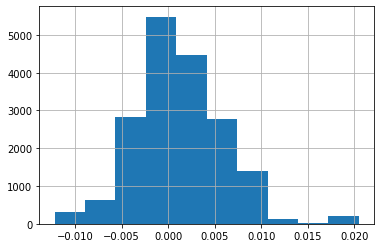

In [5]:
df['x60'].loc[df.y==0].hist()
plt.show()

# Data preprocessing

The purpose is to create an alert until 6 minutes before the break and eliminate the freezed feature (x61). Data is acquired every 2min, so the region created will consist of 3 samples. Furthermore, to avoid errors while creating the region all the working zones with less than 3 samples will be dropped. 

Some hightlights: the time features were eliminated since the period of data (less than a month) do note justify creating features like (hour, day, shift, quarter, day of week, etc.)

In [6]:
target = 'y'
# Creating 3 time shifts to build the region before break
df['y_1'] = df['y'].shift(-1)
df['y_2'] = df['y'].shift(-2)
df['y_3'] = df['y'].shift(-3)

# First generated feature
df = count_change(df,'y','count_y')

# Creates an ID for each counter reset
df = count_pikes(df,'y','count_id', True)
# ID Value adjustment - Starts at 0
df['count_id'] = df['count_id'] - df['count_id'].min()

# Deleting the downtime events and the working zones with less than 6min
df_grouped = df.groupby('count_id').max()[['count_y', target]]
ids = df_grouped.loc[(df_grouped[target] == 0) & (df_grouped['count_y'] >= 3)].index
df = df.loc[df['count_id'].isin(ids)]

# Building the region before the break
df['y'] = df.apply(lambda x: 1 if ((x['y_1'] == 1) | (x['y_2'] == 1) | (x['y_3'] == 1)) else 0, axis=1) 

# Removing target and unused columns
features = df.columns.tolist()
features.remove('time') # Unused column
features.remove('y_1')      # Aux columns
features.remove('y_2')      # ''
features.remove('y_3')      # ''
features.remove('count_id') # ''
features.remove('x61') # Freezed variable
features.remove(target)

In [7]:
print(features)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'count_y']


In [8]:
# Minority class percentage
df[target].value_counts()[1] / df.shape[0]

0.019548789836819624

In [9]:
df[features].head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,count_y
0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,1
2,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,2
3,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,3
4,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,4


In [10]:
df[['y','count_y', 'count_id']].iloc[255:263]

,y,count_y,count_id
255,0,255,0
256,1,256,0
257,1,257,0
258,1,258,0
260,0,0,2
261,0,1,2
262,0,2,2
263,0,3,2


# Data Manipulation

The first feature created was the counter variable, because it contextualizes anomalies and explains the other features condition through time.

The next step is to create the RUL variable, and for that we will use the column count_id created previously to obtain the maximum RUL value from the column count_y.

In [11]:
max_rul = df.groupby('count_id').max()['count_y'].reset_index()

In [12]:
max_rul.rename(columns={"count_y":"MAX_RUL"}, inplace=True)

In [13]:
max_rul.head()

,count_id,MAX_RUL
0,0,258
1,2,515
2,4,57
3,6,199
4,8,225


Now we will carry the MAX_RUL information to the main dataframe through a left outer join. 

In [14]:
# Left join on the count_id
df = pd.merge(df,max_rul,how='left',on='count_id')

The RUL is calculated by the difference between tha maximum RUL and the current counter value.

In [15]:
df['RUL'] = df['MAX_RUL'] - df['count_y']

Once we have calculated the RUL we can set it as the new target for the problem.

In [16]:
# Setting the new target
target = 'RUL'

In [17]:
df[['y', 'count_id', 'count_y', 'RUL']].iloc[255:263]

,y,count_id,count_y,RUL
255,0,0,255,3
256,1,0,256,2
257,1,0,257,1
258,1,0,258,0
259,0,2,0,515
260,0,2,1,514
261,0,2,2,513
262,0,2,3,512


# Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
timesteps = 5

In [20]:
# List of shifted dataframes according to the number of timesteps
df_list = [df[features].shift(shift_val) if (shift_val == 0) 
                                else df[features].shift(-shift_val).add_suffix(f'_{shift_val}') 
                                for shift_val in range(0,timesteps)]

In [21]:
# Concatenating list
df_concat = pd.concat(df_list, axis=1, sort=False)

In [22]:
df_concat = df_concat.iloc[:-timesteps,:]

In [23]:
# Default train_test_split - test_size=0.25
x_train, x_test, y_train, y_test = train_test_split(df_concat, df[target].iloc[:-timesteps], random_state=10, shuffle=True)

# Standardizing Data

Given the scale sensitivity of Recurrent Neural Networks, such as LSTM that is used in this problem, it is necessary to standardize the data. So we will use the Standard Scaler from the Scikit-Learn library  

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
# Scaling and transforming the array back to the dataframe format
# Training
x_train_lstm = pd.DataFrame(data=scaler.fit_transform(x_train), columns=x_train.columns)
# Test
x_test_lstm = pd.DataFrame(data=scaler.transform(x_test), columns=x_test.columns) 

### Regression

The approach is to use LSTM with Keras and Tensorflow. The imbalanced classes are a challenge
for this type of algorithm. The proposed idea is to transform it into a regression problem to determine the 
RUL (Remaining Useful Life) of the failure. The use of LSTM in this type of problem is more challeging regarding it's domain but it will fix the issue of imbalanced classes. 

It is necessary some work with the dataframe to define this problem:

**1 -** First we need to format the data shape so it can fit into the LSTM's required format: [samples, timesteps, features] 

- Format used [13696 samples, 5 timesteps(10 minutes), 61 features]

In [27]:
def to_3D(X, features, timesteps=5):
    '''
        Shapes the dataset so it can fit into LSTM's format requirement.
    '''
    # Creating an empty tridimensional array
    X_trans = np.empty((X.shape[0], timesteps, 0))

    # Adjusting the shape of the data
    for feat in features:
        # Regular expressions to filter each feature and
        # drop the NaN values generated from the shift
        df_filtered = X.filter(regex=f'{feat}(_|$)')
        df_filtered = df_filtered.values.reshape(df_filtered.shape[0], timesteps, 1)
        X_trans = np.append(X_trans, df_filtered, axis=2)
    
    return X_trans

<br><br>

# Building RNN architecutre

In [28]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
import keras

Using TensorFlow backend.
c:\users\danie\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\danie\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\danie\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [29]:
model = Sequential()
model.add(LSTM(input_shape=(timesteps, len(features)), units=15, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(input_shape=(timesteps,len(features)), units=10, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation = 'relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 15)             4620      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,671
Trainable params: 5,671
Non-trainable params: 0
________________________________________________________________

# Training Model

In [36]:
model_path = 'lstm_model.h5'

history = model.fit(to_3D(x_train_lstm, features), y_train, 
                    epochs=1000, batch_size= 8, validation_split=0.2, verbose=1, 
                    callbacks = [
                            keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0, 
                                                          patience=200,
                                                          verbose=1,
                                                          mode='min'),

                            keras.callbacks.ModelCheckpoint(model_path, 
                                                            monitor='val_loss',
                                                            save_best_only=True, 
                                                            mode='min',
                                                            verbose=1)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10953 samples, validate on 2739 samples
Epoch 1/1000
10953/10953 [==============================] - 9s 790us/step - loss: 52635.7738 - val_loss: 48278.8369

Epoch 00001: val_loss improved from inf to 48278.83692, saving model to lstm_model.h5
Epoch 2/1000
10953/10953 [==============================] - 8s 698us/step - loss: 48095.0048 - val_loss: 44321.1886

Epoch 00002: val_loss improved from 48278.83692 to 44321.18856, saving model to lstm_model.h5
Epoch 3/1000
10953/10953 [==============================] - 8s 743us/step - loss: 44260.4959 - val_loss: 40794.1371

Epoch 00003: val_loss improved from 44321.18856 to 40794.13708, saving model to lstm_model.h5
Epoch 4/1000
10953/10953 [==============================] - 9s 856us/step - loss: 40797.0277 - val_loss: 37646.2791

Epoch 00004: val_loss improved from 40794.13708 to 37646.27910, saving model to lstm_model.h5
Epoch 5/1000
10953/1

10953/10953 [==============================] - 9s 842us/step - loss: 3910.6077 - val_loss: 2467.0189

Epoch 00037: val_loss improved from 2699.74347 to 2467.01891, saving model to lstm_model.h5
Epoch 38/1000
10953/10953 [==============================] - 10s 913us/step - loss: 3840.0032 - val_loss: 2436.9925

Epoch 00038: val_loss improved from 2467.01891 to 2436.99249, saving model to lstm_model.h5
Epoch 39/1000
10953/10953 [==============================] - 10s 940us/step - loss: 3753.7116 - val_loss: 2449.4261

Epoch 00039: val_loss did not improve from 2436.99249
Epoch 40/1000
10953/10953 [==============================] - 10s 913us/step - loss: 3493.2975 - val_loss: 2009.0201

Epoch 00040: val_loss improved from 2436.99249 to 2009.02013, saving model to lstm_model.h5
Epoch 41/1000
10953/10953 [==============================] - 10s 871us/step - loss: 3362.8783 - val_loss: 1864.3871

Epoch 00041: val_loss improved from 2009.02013 to 1864.38712, saving model to lstm_model.h5
Epoch 42


Epoch 00079: val_loss improved from 411.45268 to 406.93589, saving model to lstm_model.h5
Epoch 80/1000
10953/10953 [==============================] - 10s 890us/step - loss: 1455.0824 - val_loss: 381.9346

Epoch 00080: val_loss improved from 406.93589 to 381.93458, saving model to lstm_model.h5
Epoch 81/1000
10953/10953 [==============================] - 10s 871us/step - loss: 1525.4564 - val_loss: 468.1891

Epoch 00081: val_loss did not improve from 381.93458
Epoch 82/1000
10953/10953 [==============================] - 9s 807us/step - loss: 1460.6527 - val_loss: 330.1367

Epoch 00082: val_loss improved from 381.93458 to 330.13667, saving model to lstm_model.h5
Epoch 83/1000
10953/10953 [==============================] - 9s 842us/step - loss: 1440.0715 - val_loss: 385.1299

Epoch 00083: val_loss did not improve from 330.13667
Epoch 84/1000
10953/10953 [==============================] - 10s 872us/step - loss: 1526.0320 - val_loss: 351.7352

Epoch 00084: val_loss did not improve from 33

10953/10953 [==============================] - 9s 854us/step - loss: 1148.2597 - val_loss: 206.9025

Epoch 00125: val_loss did not improve from 183.29691
Epoch 126/1000
10953/10953 [==============================] - 9s 859us/step - loss: 1078.8001 - val_loss: 419.2012

Epoch 00126: val_loss did not improve from 183.29691
Epoch 127/1000
10953/10953 [==============================] - 10s 883us/step - loss: 1161.8429 - val_loss: 225.9298

Epoch 00127: val_loss did not improve from 183.29691
Epoch 128/1000
10953/10953 [==============================] - 10s 887us/step - loss: 1123.2344 - val_loss: 263.2399

Epoch 00128: val_loss did not improve from 183.29691
Epoch 129/1000
10953/10953 [==============================] - 10s 888us/step - loss: 1172.3976 - val_loss: 203.5909

Epoch 00129: val_loss did not improve from 183.29691
Epoch 130/1000
10953/10953 [==============================] - 9s 801us/step - loss: 1204.9028 - val_loss: 204.4173

Epoch 00130: val_loss did not improve from 183.2969

10953/10953 [==============================] - 16s 1ms/step - loss: 988.8569 - val_loss: 242.0782

Epoch 00173: val_loss did not improve from 143.79596
Epoch 174/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 1030.6493 - val_loss: 183.3237

Epoch 00174: val_loss did not improve from 143.79596
Epoch 175/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 1001.3481 - val_loss: 204.1327

Epoch 00175: val_loss did not improve from 143.79596
Epoch 176/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 1034.8025 - val_loss: 193.4913

Epoch 00176: val_loss did not improve from 143.79596
Epoch 177/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 1071.2190 - val_loss: 215.6912

Epoch 00177: val_loss did not improve from 143.79596
Epoch 178/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 1011.2387 - val_loss: 147.0741

Epoch 00178: val_loss did not improve from 143.79596
Epoch 17

10953/10953 [==============================] - 16s 1ms/step - loss: 992.6081 - val_loss: 195.9215

Epoch 00222: val_loss did not improve from 143.79596
Epoch 223/1000
10953/10953 [==============================] - 17s 2ms/step - loss: 895.5666 - val_loss: 156.6809

Epoch 00223: val_loss did not improve from 143.79596
Epoch 224/1000
10953/10953 [==============================] - 17s 2ms/step - loss: 969.9266 - val_loss: 153.4596

Epoch 00224: val_loss did not improve from 143.79596
Epoch 225/1000
10953/10953 [==============================] - 16s 2ms/step - loss: 931.4460 - val_loss: 173.6462

Epoch 00225: val_loss did not improve from 143.79596
Epoch 226/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 984.3455 - val_loss: 192.5947

Epoch 00226: val_loss did not improve from 143.79596
Epoch 227/1000
10953/10953 [==============================] - 17s 2ms/step - loss: 911.2391 - val_loss: 204.8632

Epoch 00227: val_loss did not improve from 143.79596
Epoch 228/100

10953/10953 [==============================] - 15s 1ms/step - loss: 880.6641 - val_loss: 188.8392

Epoch 00271: val_loss did not improve from 142.30753
Epoch 272/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 898.3958 - val_loss: 173.9007

Epoch 00272: val_loss did not improve from 142.30753
Epoch 273/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 907.1510 - val_loss: 153.5956

Epoch 00273: val_loss did not improve from 142.30753
Epoch 274/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 943.5013 - val_loss: 195.6946

Epoch 00274: val_loss did not improve from 142.30753
Epoch 275/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 888.6750 - val_loss: 193.1444

Epoch 00275: val_loss did not improve from 142.30753
Epoch 276/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 876.4701 - val_loss: 167.7647

Epoch 00276: val_loss did not improve from 142.30753
Epoch 277/100

10953/10953 [==============================] - 14s 1ms/step - loss: 792.8950 - val_loss: 163.2768

Epoch 00369: val_loss did not improve from 123.90418
Epoch 370/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 810.1102 - val_loss: 176.5696

Epoch 00370: val_loss did not improve from 123.90418
Epoch 371/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 809.5602 - val_loss: 168.1454

Epoch 00371: val_loss did not improve from 123.90418
Epoch 372/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 906.8891 - val_loss: 433.5648

Epoch 00372: val_loss did not improve from 123.90418
Epoch 373/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 797.9089 - val_loss: 171.5467

Epoch 00373: val_loss did not improve from 123.90418
Epoch 374/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 802.9780 - val_loss: 199.0533

Epoch 00374: val_loss did not improve from 123.90418
Epoch 375/100

10953/10953 [==============================] - 15s 1ms/step - loss: 723.9460 - val_loss: 175.5850

Epoch 00467: val_loss did not improve from 123.90418
Epoch 468/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 737.0161 - val_loss: 179.7022

Epoch 00468: val_loss did not improve from 123.90418
Epoch 469/1000
10953/10953 [==============================] - 17s 2ms/step - loss: 759.4770 - val_loss: 158.9169

Epoch 00469: val_loss did not improve from 123.90418
Epoch 470/1000
10953/10953 [==============================] - 17s 2ms/step - loss: 758.4205 - val_loss: 204.5722

Epoch 00470: val_loss did not improve from 123.90418
Epoch 471/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 735.9091 - val_loss: 196.1962

Epoch 00471: val_loss did not improve from 123.90418
Epoch 472/1000
10953/10953 [==============================] - 15s 1ms/step - loss: 737.7928 - val_loss: 186.3386

Epoch 00472: val_loss did not improve from 123.90418
Epoch 473/100

<br><br>

# Evaluating Model

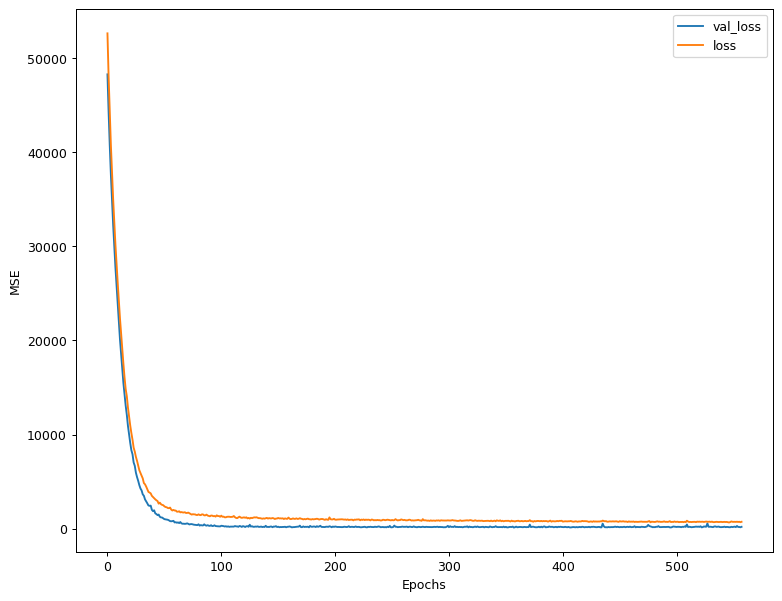

In [49]:
plt.figure(figsize=(10,8), dpi=90)
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.plot(model.history.history['loss'],label='loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

In [30]:
model.load_weights("lstm_model.h5")
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
from sklearn.metrics import r2_score
rul_pred = model.predict(to_3D(x_test_lstm,features))
print(f"R2 Score: {round(r2_score(y_test, rul_pred),4)}")

R2 Score: 0.9926


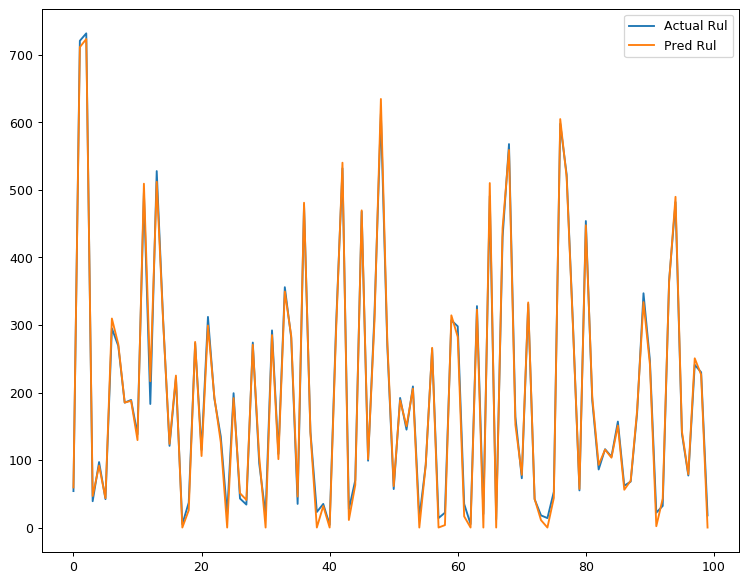

In [32]:
plt.figure(figsize = (10,8), dpi=90)
plt.plot(y_test.iloc[100:200].values,label = 'Actual Rul')
plt.plot(rul_pred[100:200],label='Pred Rul')
plt.legend()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

Converting the regression problem on classification again by setting a failure treshold(RUL Value) less or equal than 5

In [34]:
print()
y_test_class = df.y.reindex(y_test.index)
print(classification_report(y_test_class,rul_pred<=5,digits=3))
print()


              precision    recall  f1-score   support

           0      0.996     0.902     0.947      4474
           1      0.143     0.802     0.243        91

    accuracy                          0.900      4565
   macro avg      0.569     0.852     0.595      4565
weighted avg      0.979     0.900     0.933      4565




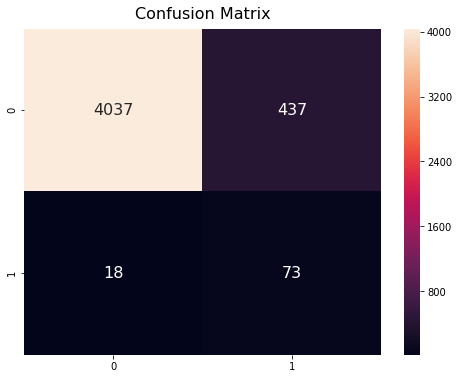

In [35]:
print("\n\n")
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix", fontdict={"size":16}, pad=10)
sns.heatmap(confusion_matrix(y_test_class,rul_pred<=5), annot=True, fmt='d', annot_kws={"size":16})
plt.show()
print()

It does not have a benchmark performance when converting it back to classification problem but it can be considered in a ensemble.

## F1 Score for different Failure Thresholds

In [36]:
from sklearn.metrics import f1_score

In [37]:
fail_thresh = np.arange(1,31)

In [38]:
f1_scores = np.array([])

for ft in fail_thresh:
    f1_scores = np.append(f1_scores, round(f1_score(y_test_class, rul_pred<=ft),4))

In [39]:
f1_scores

array([0.2478, 0.2487, 0.2504, 0.2458, 0.2429, 0.2382, 0.2325, 0.2257,
       0.2222, 0.2195, 0.2153, 0.2139, 0.2117, 0.2119, 0.2104, 0.2069,
       0.2033, 0.2029, 0.2013, 0.1997, 0.1995, 0.198 , 0.1955, 0.196 ,
       0.1961, 0.1935, 0.1912, 0.1893, 0.1874, 0.1852])

In [40]:
max_arg = np.argmax(f1_scores)
max_f1 = f1_scores[max_arg]
max_thresh = fail_thresh[max_arg]

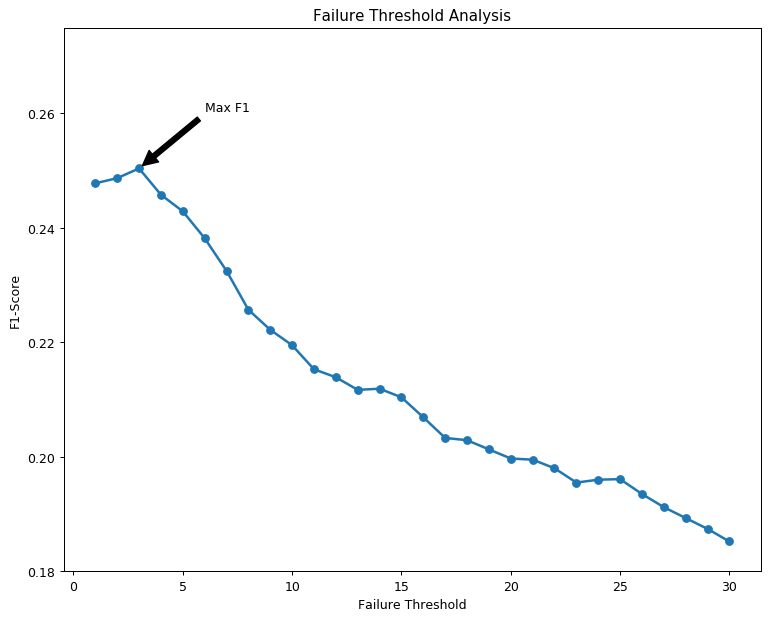

In [41]:
plt.figure(figsize=(10,8), dpi=90)
plt.title("Failure Threshold Analysis")
plt.xlabel("Failure Threshold")
plt.ylabel("F1-Score")
plt.plot(fail_thresh, f1_scores, lw=2, marker='o')
plt.annotate('Max F1', xy=(max_thresh, max_f1),
            arrowprops=dict(facecolor='black', shrink=0.05), xytext=(max_thresh+3, max_f1+0.01))
plt.ylim(0.18, 0.275)
plt.show()

As we can see in this plot the optimum value for the failure threshold is 3, obtaining the following result:

In [42]:
print()
y_test_class = df.y.reindex(y_test.index)
print(classification_report(y_test_class,rul_pred<=3,digits=3))
confusion_matrix(y_test_class,rul_pred<=3)
print()


              precision    recall  f1-score   support

           0      0.996     0.906     0.949      4474
           1      0.148     0.802     0.250        91

    accuracy                          0.904      4565
   macro avg      0.572     0.854     0.600      4565
weighted avg      0.979     0.904     0.935      4565




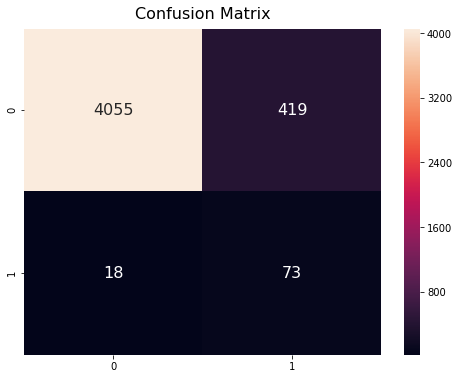

In [43]:
print("\n\n")
plt.figure(figsize=(8,6))
plt.title("Confusion Matrix", fontdict={"size":16}, pad=10)
sns.heatmap(confusion_matrix(y_test_class,rul_pred<=3), annot=True, fmt='d', annot_kws={"size":16})
plt.show()
print()


### Classification

As the regression problem we sucessful implemented, a classification problem can also been address by LSTM using Classes Weight
to compensate the imbalance problem.

In [44]:
model_class = Sequential()
model_class.add(LSTM(input_shape=(timesteps,len(features)), units=15, return_sequences=True))
model_class.add(Dropout(0.2))
model_class.add(LSTM(input_shape=(timesteps,len(features)), units=10, return_sequences=False))
model_class.add(Dropout(0.2))
model_class.add(Dense(units=1, activation = 'sigmoid'))
model_class.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 15)             4620      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,671
Trainable params: 5,671
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
model_path = 'lstm_model_classification.h5'
class_weight = {0: 1,
                1: 50} #2% are breaks ...

history = model_class.fit(to_3D(x_train_lstm, features), df['y'].reindex(y_train.index), 
                          epochs=1000, batch_size= 8, validation_split=0.2, verbose=1, class_weight=class_weight,
                          callbacks = [
                              keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            min_delta=0, 
                                                            patience=200,
                                                            verbose=1,
                                                            mode='min'),

                              keras.callbacks.ModelCheckpoint(model_path, 
                                                              monitor='val_loss',
                                                              save_best_only=True, 
                                                              mode='min',
                                                              verbose=1)])

Train on 10953 samples, validate on 2739 samples
Epoch 1/1000
10953/10953 [==============================] - 16s 1ms/step - loss: 1.1947 - acc: 0.7476 - val_loss: 1.1370 - val_acc: 0.7211

Epoch 00001: val_loss improved from inf to 1.13696, saving model to lstm_model_classification.h5
Epoch 2/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.9982 - acc: 0.7655 - val_loss: 1.0329 - val_acc: 0.7660

Epoch 00002: val_loss improved from 1.13696 to 1.03285, saving model to lstm_model_classification.h5
Epoch 3/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.8437 - acc: 0.7949 - val_loss: 0.9445 - val_acc: 0.8335

Epoch 00003: val_loss improved from 1.03285 to 0.94445, saving model to lstm_model_classification.h5
Epoch 4/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.7310 - acc: 0.8270 - val_loss: 0.8781 - val_acc: 0.8372

Epoch 00004: val_loss improved from 0.94445 to 0.87815, saving model to lstm_model_classific


Epoch 00041: val_loss did not improve from 0.61368
Epoch 42/1000
10953/10953 [==============================] - 13s 1ms/step - loss: 0.0647 - acc: 0.9846 - val_loss: 1.5258 - val_acc: 0.9785

Epoch 00042: val_loss did not improve from 0.61368
Epoch 43/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.1096 - acc: 0.9800 - val_loss: 0.8570 - val_acc: 0.9803

Epoch 00043: val_loss did not improve from 0.61368
Epoch 44/1000
10953/10953 [==============================] - 13s 1ms/step - loss: 0.0708 - acc: 0.9840 - val_loss: 1.1285 - val_acc: 0.9832

Epoch 00044: val_loss did not improve from 0.61368
Epoch 45/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0861 - acc: 0.9858 - val_loss: 0.7841 - val_acc: 0.9763

Epoch 00045: val_loss did not improve from 0.61368
Epoch 46/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0815 - acc: 0.9814 - val_loss: 0.7163 - val_acc: 0.9785

Epoch 00046: val_loss did not improve f

10953/10953 [==============================] - 15s 1ms/step - loss: 0.0273 - acc: 0.9926 - val_loss: 1.6115 - val_acc: 0.9854

Epoch 00084: val_loss did not improve from 0.44367
Epoch 85/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0569 - acc: 0.9912 - val_loss: 1.1397 - val_acc: 0.9847

Epoch 00085: val_loss did not improve from 0.44367
Epoch 86/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0461 - acc: 0.9910 - val_loss: 1.6483 - val_acc: 0.9817

Epoch 00086: val_loss did not improve from 0.44367
Epoch 87/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0482 - acc: 0.9891 - val_loss: 1.3592 - val_acc: 0.9836

Epoch 00087: val_loss did not improve from 0.44367
Epoch 88/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0560 - acc: 0.9876 - val_loss: 1.1922 - val_acc: 0.9814

Epoch 00088: val_loss did not improve from 0.44367
Epoch 89/1000
10953/10953 [===========================


Epoch 00126: val_loss did not improve from 0.44367
Epoch 127/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0761 - acc: 0.9900 - val_loss: 1.2410 - val_acc: 0.9843

Epoch 00127: val_loss did not improve from 0.44367
Epoch 128/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0398 - acc: 0.9932 - val_loss: 1.0843 - val_acc: 0.9759

Epoch 00128: val_loss did not improve from 0.44367
Epoch 129/1000
10953/10953 [==============================] - 13s 1ms/step - loss: 0.0318 - acc: 0.9921 - val_loss: 1.5868 - val_acc: 0.9843

Epoch 00129: val_loss did not improve from 0.44367
Epoch 130/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0250 - acc: 0.9943 - val_loss: 2.5123 - val_acc: 0.9869

Epoch 00130: val_loss did not improve from 0.44367
Epoch 131/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0247 - acc: 0.9955 - val_loss: 2.0615 - val_acc: 0.9865

Epoch 00131: val_loss did not impr

10953/10953 [==============================] - 14s 1ms/step - loss: 0.0227 - acc: 0.9965 - val_loss: 1.6479 - val_acc: 0.9883

Epoch 00211: val_loss did not improve from 0.44367
Epoch 212/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0118 - acc: 0.9973 - val_loss: 1.1025 - val_acc: 0.9872

Epoch 00212: val_loss did not improve from 0.44367
Epoch 213/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0099 - acc: 0.9978 - val_loss: 1.6666 - val_acc: 0.9887

Epoch 00213: val_loss did not improve from 0.44367
Epoch 214/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0381 - acc: 0.9967 - val_loss: 1.2032 - val_acc: 0.9883

Epoch 00214: val_loss did not improve from 0.44367
Epoch 215/1000
10953/10953 [==============================] - 14s 1ms/step - loss: 0.0163 - acc: 0.9965 - val_loss: 1.7695 - val_acc: 0.9890

Epoch 00215: val_loss did not improve from 0.44367
Epoch 216/1000
10953/10953 [======================

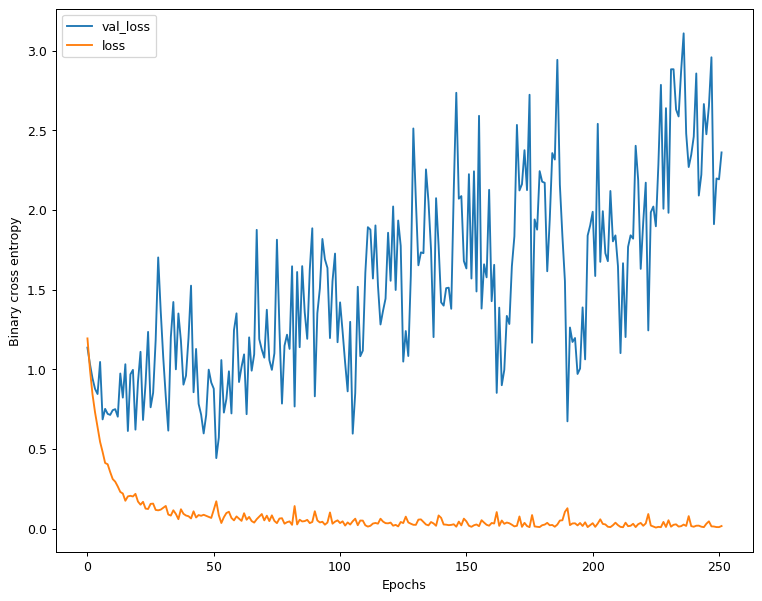

In [46]:
plt.figure(figsize=(10,8), dpi=90)
plt.plot(model_class.history.history['val_loss'], label='val_loss')
plt.plot(model_class.history.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Binary cross entropy')
plt.legend()

In [45]:
model_class.load_weights("lstm_model_classification.h5")
model_class.compile(loss='binary_crossentropy', optimizer='adam')

In [46]:
print()
print(classification_report(df['y'].reindex(y_test.index),model_class.predict_classes(to_3D(x_test_lstm, features)),digits=3))
print()


              precision    recall  f1-score   support

           0      0.997     0.974     0.985      4474
           1      0.398     0.857     0.544        91

    accuracy                          0.971      4565
   macro avg      0.697     0.915     0.764      4565
weighted avg      0.985     0.971     0.976      4565




<br><br>

# Comparing Models

Comparison between different approaches: Autoencoder as anomaly detector(Chitta), Mahalanobis distance as an anomaly detector and using LSTM with class weights as a classification model, and the RUL optimized model. 

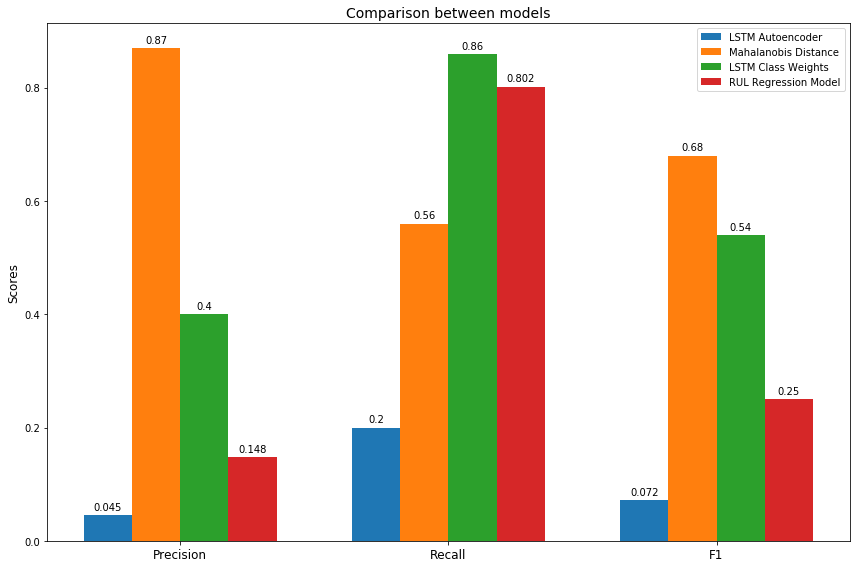

In [47]:
labels = ['Precision', 'Recall', 'F1']

# Article scores
autoencoder = [0.045, 0.20, 0.072]
maha_dist = [0.87, 0.56 , 0.68]
class_weights = [0.40, 0.86, 0.54]
rul = [0.148, 0.802, 0.250]

width = 0.18  # the width of the bars

# Set position of bar on X axis
x1 = np.arange(len(labels))
x2 = [x + width for x in x1]
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]

fig, ax = plt.subplots(figsize=(12,8))
auto_plot = ax.bar(x1, autoencoder, width, label='LSTM Autoencoder')
maha_plot = ax.bar(x2, maha_dist, width, label='Mahalanobis Distance')
class_weights_plot = ax.bar(x3, class_weights, width, label='LSTM Class Weights')
rul_plot = ax.bar(x4, rul, width, label='RUL Regression Model') 

ax.set_ylabel('Scores', fontdict={'size':12})
ax.set_title('Comparison between models', fontdict={'size':14})
ax.set_xticks(np.arange(len(labels))+ 3*width/2)
ax.set_xticklabels(labels,fontdict={'size':12})
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(auto_plot)
autolabel(maha_plot)
autolabel(class_weights_plot)
autolabel(rul_plot)
fig.tight_layout()
plt.show()